# Header

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>

# Import

In [2]:
import sys
import os
import getpass
import pandas as pd
import numpy as np
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v0.1.3 (jupyther)'
project = 'REEEM'

# Database Connection

This function creates a database connection to the **reeem_db**.<br>
The default user is **reeem_vis**, a user that has only read rights.

In [3]:
def reeem_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = '130.226.55.43' # input('host (default 130.226.55.43): ')
    port = '5432' # input('port (default 5432): ')
    database = 'reeem' # input("database name (default 'reeem'): ")
    user = 'reeem_vis' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# Access Data

This section establishes the database connection and asks for the **password**.<br>
The username can be changed in the corresponding function in the section **Database Connection** above.<br>
If you don't have a username or forgot your password please contact your database admins.

In [4]:
con = reeem_session()

C:\Anaconda3\envs\reeem-vis\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# View 0.1: Existing entries in one column

## Database Query

This section can be used to query one specific database **column** from one database table (**FROM**).<br>
The result is saved to a pandas.DataFrame (**df_0**) and printed.

In [ ]:
# Database select (SQL)
column = 'nid,category,indicator' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  {0}, count(*) AS count
    FROM    model_draft.reeem_plexos_input
    GROUP BY {0} 
    ORDER BY {0}; """.format(column))
df = pd.read_sql_query(sql, con)
df

In [ ]:
# Database select (SQL)
column = 'year' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  {0}
    FROM    model_draft.reeem_plexos_input
    GROUP BY {0} 
    ORDER BY {0}; """.format(column))
df = pd.read_sql_query(sql, con)
df

# View 0.3: Table metadata
## Database Query

This section can be used to get the metadata from one database table.<br>
The result is printed.<br>

In [5]:
# Database select (SQL)
sql = text("""SELECT obj_description('model_draft.reeem_plexos_input'::regclass);""")
df_meta = pd.read_sql_query(sql, con).loc[:,'obj_description']
df_meta

0    {"title": "REEEM Plexos Input",\n    "descript...
Name: obj_description, dtype: object

# View 3: One indicator for all regions in one pathway over time

## Database Query

This section can be used to query one specific **indicator** for all regions from one database table (_table_).<br>
Indicators are identified by the **nid** (_filter 1_).<br>
Only **region** _EU28_ is excluded (_filter 2_).<br>
It is possible to select one specific **pathway** (_filter 3_) and one specific data **version** (_filter 4_).<br>
To querry additional coulmns from the database table add the names to the **SELECT** statement (_column_).<br>
The sortation is done by the **ORDER BY** (_sorting_).<br>
The result from the database is saved to a pandas.DataFrame (**df_3**) and can be printed.

In [9]:
# Database select (SQL)
sql = text("""
    SELECT  pathway, version, region, year, nid, schema, category, indicator, value, unit  -- column
    FROM    model_draft.reeem_plexos_input -- table
    WHERE nid = 1                                 -- filter 1
        AND pathway = 'Base'                      -- filter 2
        AND version = 'DataV1'                    -- filter 3
    ORDER BY pathway, version, region, year;      -- sorting """)
df_3 = pd.read_sql_query(sql, con)
#df_3

## Metadata

The important information from the above select (**df_3**) is collected in a Dictionary (**info_dict_3**).

In [10]:
# Facts dict
info_dict_3 = {}
info_dict_3['Filename'] = ['{0}_reeem_Plexos_allregions_{1}' .format(
    pd.to_datetime('today').strftime("%Y-%m-%d"),
    df_3.loc[:,'indicator'].unique()[0])]
info_dict_3['Category'] = df_3.loc[:,'category'].unique()
info_dict_3['Indicator'] = df_3.loc[:,'indicator'].unique()
info_dict_3['Unit'] = df_3.loc[:,'unit'].unique()
info_dict_3['Pathway'] = df_3.loc[:,'pathway'].unique()
info_dict_3['Year'] = df_3.loc[:,'year'].unique().tolist()
info_dict_3['Region'] = df_3.loc[:,'region'].unique()
info_dict_3['Y-Axis'] = ['{} in {}'.format(*info_dict_3['Indicator'], *info_dict_3['Unit'])]
info_dict_3['Title'] = ['{} in all regions'.format(*info_dict_3['Category'])]
info_dict_3['Metadata'] = df_meta

# Print facts
for x in info_dict_3:
    print(x,':',info_dict_3[x])

Filename : ['2018-08-09_reeem_Plexos_allregions_Electricity Demand']
Category : ['demand extraction ']
Indicator : ['Electricity Demand']
Unit : ['TWh']
Pathway : ['Base']
Year : [2030]
Region : ['BG' 'HR' 'HU' 'RO' 'SI']
Y-Axis : ['Electricity Demand in TWh']
Title : ['demand extraction  in all regions']
Metadata : 0    {"title": "REEEM Plexos Input",\n    "descript...
Name: obj_description, dtype: object


## Stack data

This pivot function reorganises the data and makes each pathway a column. The year is used as the index.<br>
The result is saved to a new dataframe (**df_3p**) and can be printed.

In [51]:
# Reshape dataframe
df_3p = df_3.pivot(index='region', columns='indicator',  values='value')
#df_3p

## Plot

This is a basic plot with [matplotlib](https://matplotlib.org/).<br>
The title and y-axis labels are taken from the **info_dict_3**. They can be exchanged with manual text.

(0, 53.59574977950043)

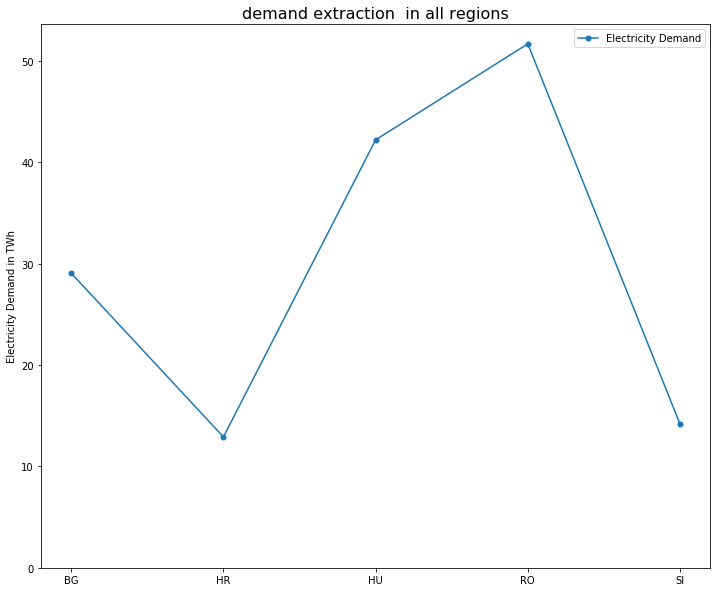

In [52]:
# Plot for one indicator and one pathway
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot()
# plt.title(r'CO2-Emissions in all regions', fontsize=16)  # Manual title
plt.title(*info_dict_3['Title'], fontsize=16)         # Title from info
# plt.ylabel(r'CO2-Emissions in Mt')                # Manual label
plt.ylabel(*info_dict_3['Y-Axis'])                    # Label from info
plt.plot(df_3p, 
         marker="o",  markersize=5)
plt.legend(df_3p)
ax.set_ylim(ymin=0)

## Interactive Plot

This is a basic interactive plot with [Plotly](https://plot.ly/python/).<br>
You can hover over the elements of the plot and observe the data.<br>
The different pathways can be switched on and off.

In [57]:
# Iterate over pathways and add to data
regions = df_3.loc[:,'region'].unique()
data = []
for region in regions:
    data.append(go.Scatter(
        x = df_3.loc[df_3['region'] == region].loc[:,'region'],
        y = df_3.loc[df_3['region'] == region].loc[:,'value'],
        name = region))

# Set layout
layout = go.Layout(
    height=800, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_3['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_3['Y-Axis'])) )
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.<br>

In [14]:
# Write facts to textfile
filename = ('data/{}.txt').format(*info_dict_3['Filename'])
with open(filename,'w') as tfile:
    for i in info_dict_3.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict_3[i]]) + "\n")
tfile.close()
print("Facts saved to file:", filename)

# Save data to CSV
csvname = 'data/{}.csv' .format(*info_dict_3['Filename'])
df_3.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save pivot data to CSV
csvname = 'data/{}_pivot.csv' .format(*info_dict_3['Filename'])
df_3p.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict_3['Filename'])
fig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict_3['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

Facts saved to file: data/2018-08-09_reeem_Plexos_allregions_Electricity Demand.txt
Data saved to file: data/2018-08-09_reeem_Plexos_allregions_Electricity Demand.csv
Data saved to file: data/2018-08-09_reeem_Plexos_allregions_Electricity Demand_pivot.csv
Plot saved to file: data/2018-08-09_reeem_Plexos_allregions_Electricity Demand.png
Interactive plot saved to file: data/2018-08-09_reeem_Plexos_allregions_Electricity Demand.html


# View 4: All indicators for one region in one pathway over time

## Database Query

This section can be used to query all **indicators** for one **region** (_filter 2_) from one database table (_table_).<br>
Indicators are identified by the **nid**.<br>
It is possible to select one specific **pathway** (_filter 3_) and one specific data **version** (_filter 4_).<br>
To querry additional coulmns from the database table add the names to the **SELECT** statement (_column_).<br>
The sortation is done by the **ORDER BY** (_sorting_).<br>
The result from the database is saved to a pandas.DataFrame (**df_4**) and can be printed.

In [36]:
# Database select (SQL)
sql = text("""
    SELECT  pathway, version, region, year, nid, indicator, category, value, unit  -- column
    FROM    model_draft.reeem_plexos_input
    WHERE   category = 'Installed Generation Capacities'
        AND region = 'BG'
        AND pathway = 'Base'
        AND version = 'DataV1'
    ORDER BY pathway, version, year, region, nid; """)
df_4 = pd.read_sql_query(sql, con)
#print(df_4)

## Metadata

The important information from the above select (**df_4**) is collected in a Dictionary (**info_dict_4**).

In [45]:
# Facts dict
info_dict_4 = {}
info_dict_4['Filename'] = ['{0}_reeem_Plexos_allindicators_{1}' .format(
    pd.to_datetime('today').strftime("%Y-%m-%d"),
    df_4.loc[:,'region'].unique()[0])]
info_dict_4['Category'] = df_4.loc[:,'category'].unique()
info_dict_4['Indicator'] = df_4.loc[:,'indicator'].unique()
info_dict_4['Unit'] = df_4.loc[:,'unit'].unique()
info_dict_4['Pathway'] = df_4.loc[:,'pathway'].unique()
info_dict_4['Year'] = df_4.loc[:,'year'].unique().tolist()
info_dict_4['Region'] = df_4.loc[:,'region'].unique()
info_dict_4['Y-Axis'] = ['{} in {}'.format(*info_dict_4['Category'],*info_dict_4['Unit'])]
info_dict_4['Title'] = ['{} in region {}'.format(*info_dict_4['Category'],*info_dict_4['Region'])]
info_dict_4['Metadata'] = df_meta

# Print facts
for x in info_dict_4:
    print(x,':',info_dict_4[x])

Filename : ['2018-08-09_reeem_Plexos_allindicators_BG']
Category : ['Installed Generation Capacities']
Indicator : ['Coal' 'Lignite' 'Oil' 'Natural Gas / non renew.' 'Nuclear'
 'Waste non renewable + Industrial Waste Heat'
 'Biomass solid / Waste ren.' 'Biogas / Biofuel' 'Hydro' 'Wind' 'Solar'
 'Geothermal' 'Ocean' 'Hydrogen' 'Electricity Storage']
Unit : ['MW']
Pathway : ['Base']
Year : [2030]
Region : ['BG']
Y-Axis : ['Installed Generation Capacities in MW']
Title : ['Installed Generation Capacities in region BG']
Metadata : 0    {"title": "REEEM Plexos Input",\n    "descript...
Name: obj_description, dtype: object


## Stack data

This pivot function reorganises the data and makes each year a column. The indicator is used as the index.<br>
The result is saved to a new dataframe (**df_4p**) and can be printed.

In [48]:
# Reshape dataframe
df_4p = df_4.pivot(index='indicator', columns='region',  values='value')
#df_4p

## Plot

This is a basic plot with [matplotlib](https://matplotlib.org/).<br>
The title and y-axis labels are taken from the **info_dict_4**. They can be exchanged with manual text.

(0, 4833.276)

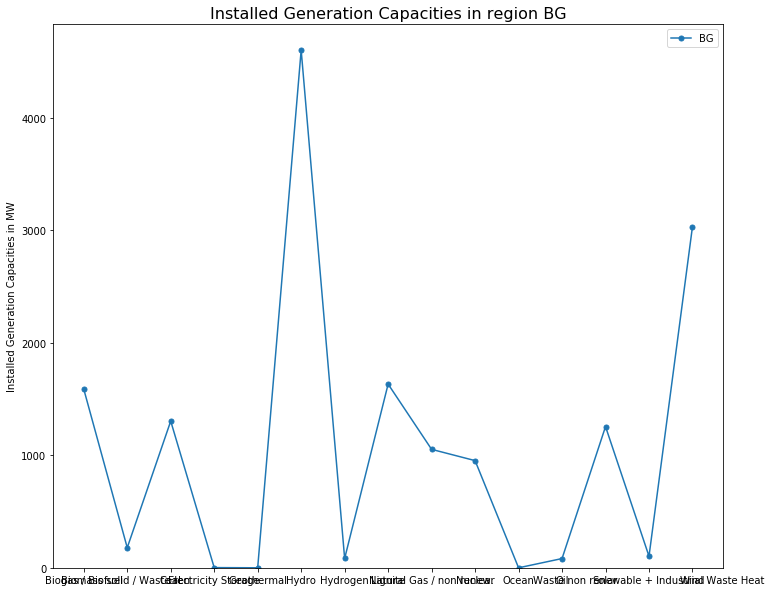

In [50]:
# Plot for one indicator and one pathway
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot()
# plt.title(r'All indicators in region {}', fontsize=16)   # Manual title
plt.title(*info_dict_4['Title'], fontsize=16)         # Title from info
# plt.ylabel(r'CO2-Emissions in Mt')                # Manual label
plt.ylabel(*info_dict_4['Y-Axis'])                    # Label from info
plt.plot(df_4p, 
         marker="o",  markersize=5)
plt.legend(df_4p)
ax.set_ylim(ymin=0)

## Interactive Plot

This is a basic interactive plot with [Plotly](https://plot.ly/python/).<br>
You can hover over the elements of the plot and observe the data.<br>
The different pathways can be switched on and off.

In [59]:
# Iterate over pathways and add to data
indicators = df_4.loc[:,'indicator'].unique()
data = []
for indicator in indicators:
    data.append(go.Scatter(
        x = df_4.loc[df_4['indicator'] == indicator].loc[:,'region'],
        y = df_4.loc[df_4['indicator'] == indicator].loc[:,'value'],
        name = indicator))

# Set layout
layout = go.Layout(
    height=800, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_4['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_4['Y-Axis'])) )
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.<br>

In [60]:
# Write facts to textfile
filename = ('data/{}.txt').format(*info_dict_4['Filename'])
with open(filename,'w') as tfile:
    for i in info_dict_4.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict_4[i]]) + "\n")
tfile.close()
print("Facts saved to file:", filename)

# Save data to CSV
csvname = 'data/{}.csv' .format(*info_dict_4['Filename'])
df_4.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save pivot data to CSV
csvname = 'data/{}_pivot.csv' .format(*info_dict_4['Filename'])
df_4p.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict_4['Filename'])
fig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict_4['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

Facts saved to file: data/2018-08-09_reeem_Plexos_allindicators_BG.txt
Data saved to file: data/2018-08-09_reeem_Plexos_allindicators_BG.csv
Data saved to file: data/2018-08-09_reeem_Plexos_allindicators_BG_pivot.csv
Plot saved to file: data/2018-08-09_reeem_Plexos_allindicators_BG.png
Interactive plot saved to file: data/2018-08-09_reeem_Plexos_allindicators_BG.html
